# Case: Score de crédito

O score de crédito é uma importante ferramenta para instituições financeiras. Com ele, é possível estimar o risco de fornecer crédito a um cliente que o solicitou, reduzindo riscos de prejuízo por parte da instituição financeira por conta de inadimplência. De acordo com dados da [Serasa Experian](https://cdn.builder.io/o/assets%2Fb212bb18f00a40869a6cd42f77cbeefc%2F63e097304b0446f48433934a6685a388?alt=media&token=dab540dc-1f00-4809-9999-7407aa3e39fd&apiKey=b212bb18f00a40869a6cd42f77cbeefc), em Agosto de 2024, o número de pessoas inadimplentes no Brasil era de 72,5 milhões, representando uma dívida total de R$ 390,5 bilhões.

A determinação de um score de crédito pode ser complexa, são diversos fatores que influenciam na probabilidade de inadimplência de um devedor.

## Sumário

## Imports

Seção destinada à importação de bibliotecas, definições de funções e importação dos dados disponíveis

In [1]:
import os
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
# Mudar o diretório de trabalho para o diretório do projeto
os.chdir("/Users/gustavosantos/code/credit-score")
display(os.getcwd())

'/Users/gustavosantos/code/credit-score'

In [2]:
df_info = pd.read_csv("data/base_info.csv")
df_pagamentos = pd.read_csv("data/base_pagamentos_desenvolvimento.csv")
df_cadastral = pd.read_csv("data/base_cadastral.csv")
df_pagamentos_teste = pd.read_csv("data/base_pagamentos_teste.csv")

## Entendendo os dados

Esta seção fornece uma visão detalhada da estrutura e do significado dos dados que serão analisados

### Dicionário de variáveis

1. **Base Info** (`df_info`):
    * **Chaves primárias (PK):** são as colunas que servem de referência para a agregação com as outras bases, cada par desses atributos deve aparecer apenas uma vez nessa base
        - `ID_CLIENTE`: Identificador único do cliente.
        - `SAFRA_REF`: Mês de referência da amostra.

    * **Outros atributos:**
        - `RENDA_MES_ANTERIOR`: Renda ou faturamento declarado pelo cliente no fim do mês anterior.
        - `NO_FUNCIONARIOS`: Número de funcionários reportado pelo cliente no fim do mês anterior.

2. **Base Cadastral** (`df_cadastral`):
    * **Chave primária:**
        - `ID_CLIENTE`: Identificador único do cliente. Servirá para realizar a junção com a coluna de mesmo nome na Base Info.

    * **Outros atributos:**
        - `DATA_CADASTRO`: Data da realização do cadastro no sistema. 
        - `DDD`: Número do DDD do telefone do cliente. 
        - `FLAG_PF`: Indica se o cliente é um pessoa física ('X') ou jurídica ('NaN')
        - `SEGMENTO_INSTUSTRIAL`: Indica a qual segmento da indústria pertence o cliente
        - `DOMINIO_EMAIL`: Indica o domínio (ou provedor) do email utilizado para o cadastro. 
        - `PORTE`: Indica o porte (tamanho) da empresa.
        - `CEP_2DIG`: Indica os dois primeiros números do CEP do endereço cadastrados.

3. **Base pagamentos** (`df_pagamentos` e `df_pagamentos_teste`):
    * **Chaves estrangeiras (FK):** são as colunas que servem de referência para a Base Info e Base Cadastral
        - `ID_CLIENTE`: Identificador único do cliente.
        - `SAFRA_REF`: Mês de referência da amostra.
    * **Outros atributos:**
        - `DATA_EMISSAO_DOCUMENTO`: Data da emissão da nota de crédito.
        - `DATA_VENCIMENTO`: Data limite para pagamento do empréstimo.
        - `VALOR_A_PAGAR`: Valor da nota de crédito.
        - `TAXA`: Taxa de jurso cobrada no empréstimo.
        - `DATA_PAGAMENTO`: Data em que o cliente realizou o pagamento da nota. Disponível apenas na base de desenvolvimento (`df_pagamentos`).
    * **Atributos a serem criados:**
        - `INADIMPLENTE`: Indica se o cliente é inadimplente (1) ou não (0). Um cliente será considerado inadimplente quando a diferença entre as datas de vencimento e pagamento for maior ou igual a 5 dias.


### Exploração inicial dos dados

As bases disponibilizadas serão exploradas individualmente para depois serem unidas

In [3]:
# Ver as 3 primeiras linhas de cada dataframe
print("Base Info")
display(df_info.head(3))
print("Bases Pagamentos")
display(df_pagamentos.head(3))
display(df_pagamentos_teste.head(3))
print("Base Cadastral")
display(df_cadastral.head(3))

Base Info


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,92.0
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0


Bases Pagamentos


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99


Base Cadastral


,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,NaN,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,NaN,Serviços,HOTMAIL,PEQUENO,48


É possível perceber que todas as colunas descritas estão presentes nas bases. Além disso, a coluna `DATA_EMISSAO_DOCUMENTO` parece ser desncessária, uma vez que a coluna `SAFRA_REF` já traz a informação sobre o mês de emissão do documento de crédito.

In [4]:
# Visualizar tamanho dos dataframes
print("Tamanho dos dataframes")
print("Base Info")
print(f"Entradas: {df_info.shape[0]}")
print(f"Variáveis: {df_info.shape[1]}")
print("-" * 20)

print("Bases Pagamentos")
print(f"Entradas: {df_pagamentos.shape[0]}")
print(f"Variáveis: {df_pagamentos.shape[1]}")
print("-" * 20)

print("Base Teste")
print(f"Entradas: {df_pagamentos_teste.shape[0]}")
print(f"Variáveis: {df_pagamentos_teste.shape[1]}")
print("-" * 20)

print("Base Cadastral")
print(f"Entradas: {df_cadastral.shape[0]}")
print(f"Variáveis: {df_cadastral.shape[1]}")

Tamanho dos dataframes
Base Info
Entradas: 24401
Variáveis: 4
--------------------
Bases Pagamentos
Entradas: 77414
Variáveis: 7
--------------------
Base Teste
Entradas: 12275
Variáveis: 6
--------------------
Base Cadastral
Entradas: 1315
Variáveis: 8


In [5]:
# Tipos de variáveis para base info
print("Tipos de variáveis para base info")
print(df_info.dtypes)

Tipos de variáveis para base info
ID_CLIENTE              int64
SAFRA_REF              object
RENDA_MES_ANTERIOR    float64
NO_FUNCIONARIOS       float64
dtype: object


In [6]:
# Tipos de variáveis para base pagamentos
print("Tipos de variáveis para base pagamentos")
print(df_pagamentos.dtypes)

Tipos de variáveis para base pagamentos
ID_CLIENTE                  int64
SAFRA_REF                  object
DATA_EMISSAO_DOCUMENTO     object
DATA_PAGAMENTO             object
DATA_VENCIMENTO            object
VALOR_A_PAGAR             float64
TAXA                      float64
dtype: object


As colunas ``DATA_EMISSAO_DOCUMENTO``, ``DATA_PAGAMENTO`` e ``DATA_VENCIMENTO`` estão em formato de texto e deverão ser transformadas em formato de data

In [7]:
# Tipos de variáveis para base teste
print("Tipos de variáveis para base teste")
print(df_pagamentos_teste.dtypes)

Tipos de variáveis para base teste
ID_CLIENTE                  int64
SAFRA_REF                  object
DATA_EMISSAO_DOCUMENTO     object
DATA_VENCIMENTO            object
VALOR_A_PAGAR             float64
TAXA                      float64
dtype: object


In [8]:
# Tipos de variáveis para base cadastral
print("Tipos de variáveis para base cadastral")
print(df_cadastral.dtypes)

Tipos de variáveis para base cadastral
ID_CLIENTE              int64
DATA_CADASTRO          object
DDD                    object
FLAG_PF                object
SEGMENTO_INDUSTRIAL    object
DOMINIO_EMAIL          object
PORTE                  object
CEP_2_DIG              object
dtype: object


In [9]:
# Verificar se cada id tem apenas um registro na base
print("Número de IDs únicos na base cadastral")
print(df_cadastral["ID_CLIENTE"].nunique())
print("Número de registros na base cadastral")
print(df_cadastral.shape[0])

Número de IDs únicos na base cadastral
1315
Número de registros na base cadastral
1315


O fato de a coluna `DDD` não ser numérica pode indicar que há alguma inconsistência nas entradas dessa coluna

In [10]:
unique_ddd = df_cadastral["DDD"].unique()
unique_ddd

array(['99', '31', '75', '49', '88', '18', '67', '21', '11', '44', nan,
       '19', '14', '16', '85', '41', '51', '12', '62', '43', '91', '42',
       '61', '33', '48', '71', '65', '38', '24', '(3', '47', '28', '(2',
       '81', '35', '13', '86', '94', '45', '17', '55', '64', '69', '32',
       '(6', '27', '66', '63', '46', '(1', '54', '77', '34', '74', '37',
       '53', '56', '95', '22', '73', '(9', '(4', '52', '87', '98', '(8',
       '92', '82', '79', '93', '83', '00', '(5', '15', '02', '84', '(0',
       '04', '07', '(7'], dtype=object)

De fato há valores fornecidos para a variável `DDD` que não são válidos. Como a variável `DDD` seria representativa apenas para localizacão do cliente e já temos a coluna `CEP` com dois dígitos, que representam a região e subregião de acordo com os [Correios](https://www.correios.com.br/enviar/precisa-de-ajuda/imagens/tudo-sobre-cep/cep-desktop), essa coluna pode ser utilizada como localizador do cliente, caso seja necessário.

Por isso, não trateremos as inconsistências da coluna `DDD` da base cadastral.

In [11]:
# Porcentagem de valores faltantes ou nulos
print("Porcentagem de valores faltantes ou nulos para base info")
print((df_info.isnull().sum() / df_info.shape[0] * 100).round(2))

Porcentagem de valores faltantes ou nulos para base info
ID_CLIENTE            0.0
SAFRA_REF             0.0
RENDA_MES_ANTERIOR    0.0
NO_FUNCIONARIOS       0.0
dtype: float64


In [12]:
print("Porcentagem de valores faltantes ou nulos para base pagamentos")
print((df_pagamentos.isnull().sum() / df_pagamentos.shape[0] * 100).round(2))

Porcentagem de valores faltantes ou nulos para base pagamentos
ID_CLIENTE                0.0
SAFRA_REF                 0.0
DATA_EMISSAO_DOCUMENTO    0.0
DATA_PAGAMENTO            0.0
DATA_VENCIMENTO           0.0
VALOR_A_PAGAR             0.0
TAXA                      0.0
dtype: float64


In [13]:
print("Porcentagem de valores faltantes ou nulos para base teste")
print(
    (df_pagamentos_teste.isnull().sum() / df_pagamentos_teste.shape[0] * 100).round(2)
)

Porcentagem de valores faltantes ou nulos para base teste
ID_CLIENTE                0.0
SAFRA_REF                 0.0
DATA_EMISSAO_DOCUMENTO    0.0
DATA_VENCIMENTO           0.0
VALOR_A_PAGAR             0.0
TAXA                      0.0
dtype: float64


In [14]:
print("Porcentagem de valores faltantes ou nulos para base cadastral")
print((df_cadastral.isnull().sum() / df_cadastral.shape[0] * 100).round(2))

Porcentagem de valores faltantes ou nulos para base cadastral
ID_CLIENTE              0.00
DATA_CADASTRO           0.00
DDD                    18.02
FLAG_PF                94.98
SEGMENTO_INDUSTRIAL     6.31
DOMINIO_EMAIL           2.28
PORTE                   3.12
CEP_2_DIG               0.00
dtype: float64


A coluna `FLAG_PF` da base cadastral contém 94,98% de valores nulos. O nulo, como indicado no dicionário de variáveis, indica que o registro na base é referente a uma pessoa jurídica. As outras colunas, como `SEGMENTO_INDUSTRIAL` podem ter relação com a coluna `FLAG_PF` uma vez que não faria sentido registrar o segmento industrial de uma pessoa física.

Vamos analisá-las a seguir.

In [15]:
# Verificar se os valores nulos de segmento industrial são de pessoas físicas ou jurídicas
df_cadastral[(df_cadastral["SEGMENTO_INDUSTRIAL"].isnull())]["FLAG_PF"].value_counts(
    dropna=False
)

FLAG_PF
X      66
NaN    17
Name: count, dtype: int64

In [16]:
df_cadastral["SEGMENTO_INDUSTRIAL"].unique()

array(['Serviços', 'Comércio', 'Indústria', nan], dtype=object)

A exploração acima mostra que das aparições nulas da coluna `SEGMENTO_INDUSTRIAL`, 66 casos são de pessoas físicas, que representam todos os registros de pessoas físicas, o que faz sentido, uma vez que segmento industrial é uma informação que não faz sentido para pessoas físicas. Nesses registros, os valores nulos serão imputados com o valor -1.

Para os 17 casos restantes, vamos considerar que o segmento industrial da empresa cadastrada não se encaixa nas três possibilidades fornecidas e associaremos a "Outro".

In [17]:
# Verificar se os valores nulos de porte são de pessoas físicas ou jurídicas
df_cadastral[(df_cadastral["PORTE"].isnull())]["FLAG_PF"].value_counts(dropna=False)

FLAG_PF
NaN    39
X       2
Name: count, dtype: int64

Como os valores nulos da coluna `PORTE` não são apenas de pessoas físicas, será necessário pensar em uma estratégia de como tratá-los antes de passar essa informação para o modelo.

In [18]:
# Avaliar a distribuição de porte por segmento industrial
df_cadastral.groupby(["SEGMENTO_INDUSTRIAL"])["PORTE"].value_counts(dropna=False)

SEGMENTO_INDUSTRIAL  PORTE  
Comércio             GRANDE     170
                     MEDIO      163
                     PEQUENO     81
                     NaN         17
Indústria            MEDIO      133
                     GRANDE      96
                     PEQUENO     60
                     NaN          9
Serviços             MEDIO      197
                     GRANDE     181
                     PEQUENO    113
                     NaN         12
Name: count, dtype: int64

Pelas distribuições apresentadas acima, inputar a moda do segmento do cliente pode ser uma boa saída para tratar os dados faltantes. Essa inputação deve, no entanto, ser realizada somente depois da separação dos conjuntos de treino, teste e validação, para evitar vazamento de dados.

### Conclusões

Com base na exploração inicial, conclui-se que serão necessárias as seguintes alterações nas colunas abaixo:

- Criação da coluna `INADIMPLENTE`na base pagamentos. Terá valor `TRUE` se o pagamento foi realizado 5 ou mais dias depois da data de vencimento.
- Remoção da coluna `DDD` da base cadastral. A informação de localização, para a qual esse atributo poderia ser utilizado como *proxy*, também pode ser obtida a partir dos 2 primeiros dígitos do CEP
- Remoção da coluna `DOMINIO_EMAIL`. A informação não parece ter valor preditivo na tarefa final.
- Adição de entrada "Outro" nos valores faltantes da coluna `SEGMENTO_INDUSTRIAL` caso a entrada seja de pessoa jurídica e do valor -1 caso a entrada seja de pessoa física.
- Inputação da moda por segmento da indústria nos dados faltantes da coluna `PORTE`. <mark>Essa transformação será realizada apenas após a separação dos conjuntos de treinamento</mark>.

### Pré-processamento

Para realização de análises univariadas e bivariadas, será necessário tratar os pontos levantados ao longo da seção anterior.

In [19]:
# Transformar colunas com datas em datetime
df_pagamentos[["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO", "DATA_PAGAMENTO"]] = (
    df_pagamentos[
        ["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO", "DATA_PAGAMENTO"]
    ].apply(pd.to_datetime)
)

# Criar coluna com a diferença entre a data de vencimento e a data de pagamento
df_pagamentos["DIFERENCA_DIAS"] = (
    df_pagamentos["DATA_PAGAMENTO"] - df_pagamentos["DATA_VENCIMENTO"]
).dt.days

# Criar coluna de inadimplência (DIFERENCA_DIAS > 5)
df_pagamentos["INADIMPLENTE"] = df_pagamentos["DIFERENCA_DIAS"] > 5

In [20]:
df_pagamentos.head(3)

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIFERENCA_DIAS,INADIMPLENTE
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,False
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1,False
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1,False


In [21]:
df_pagamentos_teste[["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO"]] = (
    df_pagamentos_teste[
        ["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO"]
    ].apply(pd.to_datetime)
)

In [22]:
# Substituir "X" por 1 e preencher valores nulos com 0 na coluna FLAG_PF
df_cadastral["FLAG_PF"] = df_cadastral["FLAG_PF"].map({"X": 1})
df_cadastral["FLAG_PF"] = df_cadastral["FLAG_PF"].fillna(0)

# Remover coluna DDD
df_cadastral = df_cadastral.drop("DDD", axis=1)
# Remover coluna DOMINIO_EMAIL
df_cadastral = df_cadastral.drop("DOMINIO_EMAIL", axis=1)

# Adicionar classe Outros para valores nulos em SEGMENTO_INDUSTRIAL de pessoas júridicas
df_cadastral.loc[
    (df_cadastral["SEGMENTO_INDUSTRIAL"].isnull()) & (df_cadastral["FLAG_PF"] == 0),
    "SEGMENTO_INDUSTRIAL",
] = "Outro"

# Adicionar classe -1 para valores nulos em SEGMENTO_INDUSTRIAL de pessoas físicas
df_cadastral.loc[
    (df_cadastral["SEGMENTO_INDUSTRIAL"].isnull()) & (df_cadastral["FLAG_PF"] == 1),
    "SEGMENTO_INDUSTRIAL",
] = -1

df_cadastral.head()

,ID_CLIENTE,DATA_CADASTRO,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,0.0,Serviços,PEQUENO,65
1,8274986328479596038,2017-01-25,0.0,Comércio,MEDIO,77
2,345447888460137901,2000-08-15,0.0,Serviços,PEQUENO,48
3,1003144834589372198,2017-08-06,0.0,Serviços,PEQUENO,89
4,324916756972236008,2011-02-14,0.0,Serviços,GRANDE,62


In [23]:
df_cadastral.isna().sum()

ID_CLIENTE              0
DATA_CADASTRO           0
FLAG_PF                 0
SEGMENTO_INDUSTRIAL     0
PORTE                  41
CEP_2_DIG               0
dtype: int64

Resolvidas as inconsistências de `df_cadastral`, vamos juntar as bases de dados em um único dataframe.

A união dos dataframes se dará da seguinte forma:
1. Left join* de `df_pagamentos` com `df_cadastral`. Resultando na versão parcial de `df_modelagem`.
2. Left join* de `df_modelagem` com `df_info`. Resultando na versão completa de `df_modelagem`.

Para a união se utilizará a função `pandas.merge()` na coluna `ID_CLIENTE` para a etapa 1. e nas colunas `ID_CLIENTE` e `SAFRA_REF` na etapa 2.


\*A left join retorna todas as entradas do primeiro dataframe e apenas as entradas em que há *match* na(s) coluna(s) chave do segundo dataframe.

No conjunto de teste, serão realizadas as mesmas uniões, substituindo o `df_pagamentos` pelo `df_pagamentos_teste`. Essas etapas resultarão no dataframe `df_teste`,

In [24]:
# Une df_pagamentos com df_cadastral
df_modelagem = pd.merge(
    df_pagamentos,
    df_cadastral,
    on="ID_CLIENTE",
    how="left",
    suffixes=("", "_cadastral"),
)

# Une df_modelagem com df_info
df_modelagem = pd.merge(
    df_modelagem,
    df_info,
    on=["ID_CLIENTE", "SAFRA_REF"],
    how="left",
    suffixes=("", "_info"),
)

In [25]:
df_teste = pd.merge(
    df_pagamentos_teste,
    df_cadastral,
    on="ID_CLIENTE",
    how="left",
    suffixes=("", "_cadastral"),
)

df_teste = pd.merge(
    df_teste,
    df_info,
    on=["ID_CLIENTE", "SAFRA_REF"],
    how="left",
    suffixes=("", "_info"),
)

In [26]:
df_modelagem.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIFERENCA_DIAS,INADIMPLENTE,DATA_CADASTRO,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,False,2013-08-22,0.0,Serviços,PEQUENO,65,NaN,NaN
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1,False,2013-08-22,0.0,Serviços,PEQUENO,65,NaN,NaN
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1,False,2013-08-22,0.0,Serviços,PEQUENO,65,NaN,NaN
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6,True,2013-08-22,0.0,Serviços,PEQUENO,65,NaN,NaN
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,False,2013-08-22,0.0,Serviços,PEQUENO,65,NaN,NaN


In [27]:
df_modelagem.isna().sum()

ID_CLIENTE                   0
SAFRA_REF                    0
DATA_EMISSAO_DOCUMENTO       0
DATA_PAGAMENTO               0
DATA_VENCIMENTO              0
VALOR_A_PAGAR                0
TAXA                         0
DIFERENCA_DIAS               0
INADIMPLENTE                 0
DATA_CADASTRO                0
FLAG_PF                      0
SEGMENTO_INDUSTRIAL          0
PORTE                     2476
CEP_2_DIG                    0
RENDA_MES_ANTERIOR        3937
NO_FUNCIONARIOS           3937
dtype: int64

A união dos dataframes gerou novos dados faltantes. São dados em que não há registro na base info mas que estão presentes na base pagamentos. Como isso pode ocorrer num caso real, como é o caso do `df_pagamentos_teste`, ilustrado abaixo, é necessário tratar esses dados.

A estratégia adotada será inputar ambos os valores de `RENDA_MES_ANTERIOR` quanto `NO_FUNCIONARIOS` com a média da combinação `PORTE` e `SEGMENTO_INDUSTRIAL` daquela amostra para os conjuntos de treino, validação e teste. <mark>Assim como para a inputação da coluna `PORTE`, é necessário esperar a divisão dos conjuntos para realizar a imputação</mark>

In [28]:
df_teste.isna().sum()

ID_CLIENTE                  0
SAFRA_REF                   0
DATA_EMISSAO_DOCUMENTO      0
DATA_VENCIMENTO             0
VALOR_A_PAGAR               0
TAXA                        0
DATA_CADASTRO              38
FLAG_PF                    38
SEGMENTO_INDUSTRIAL        38
PORTE                     416
CEP_2_DIG                  38
RENDA_MES_ANTERIOR        414
NO_FUNCIONARIOS           414
dtype: int64

In [29]:
df_teste[df_teste["FLAG_PF"].isna()].head(10)

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DATA_CADASTRO,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
3632,5562543665139612149,2021-07,2021-07-29,2021-08-20,19791.50,8.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3871,1166653268490470189,2021-08,2021-08-08,2021-08-23,40600.00,11.99,NaN,NaN,NaN,NaN,NaN,56699.0,126.0
3872,1166653268490470189,2021-08,2021-08-12,2021-08-27,40600.00,11.99,NaN,NaN,NaN,NaN,NaN,56699.0,126.0
6362,8750634267020436314,2021-09,2021-09-02,2021-10-08,4189.50,6.99,NaN,NaN,NaN,NaN,NaN,198446.0,99.0
6455,5562543665139612149,2021-09,2021-09-07,2021-09-29,28259.00,5.99,NaN,NaN,NaN,NaN,NaN,219052.0,124.0
6456,5562543665139612149,2021-09,2021-09-09,2021-10-01,20185.00,5.99,NaN,NaN,NaN,NaN,NaN,219052.0,124.0
6474,9016049685460415544,2021-09,2021-09-08,2021-10-08,8397.59,4.99,NaN,NaN,NaN,NaN,NaN,43537.0,119.0
6507,4228701400180066884,2021-09,2021-09-12,2021-10-07,132.28,4.99,NaN,NaN,NaN,NaN,NaN,113845.0,106.0
6509,1040994770557588198,2021-09,2021-09-12,2021-10-07,3509.99,5.99,NaN,NaN,NaN,NaN,NaN,635426.0,146.0
6517,5706551050445880395,2021-09,2021-09-12,2021-10-07,4008.00,8.99,NaN,NaN,NaN,NaN,NaN,571804.0,118.0


A tabela ilustrada acima mostra que há vários dados faltantes na base de teste final. Isto se dá porque não há registro desses clientes na base cadastral. Será necessário pensar em formas de como atacar esse problema no momento de se fazer um previsão para dados de clientes não cadastrados. <mark>A forma como isso será solucionado será descrita no momento oportuno</mark>

[//]: <> (Uma sugestão seria fazer um baseline que usa apenas os dados disponíveis e outro modelo com dados completos)
[//]: <> (Pode ser que o próprio baseline já seja suficiente e não seja necessário ter esses dados para se fazer uma previsão)
[//]: <> (O baseline poderia ser aplicado quando esses dados estiverem faltando e o outro quando tivermos a informação completa: COMO DIMINUIR A CONFIANÇA DO MODELO PARA O PRIMEIRO CASO?)

## Análise exploratória dos dados

Exploram-se abaixo as estatísticas, distribuições e relações entre os dados

### Análise univariada

#### Variáveis categóricas

Variáveis categóricas são aquelas que assumem valores dentro de um rol de possibilidades. No *dataset* as variáveis categóricas são: `FLAG_PF`, `SEGMENTO_INDUSTRIAL`, `PORTE` e a variável alvo `INADIMPLENTE`.

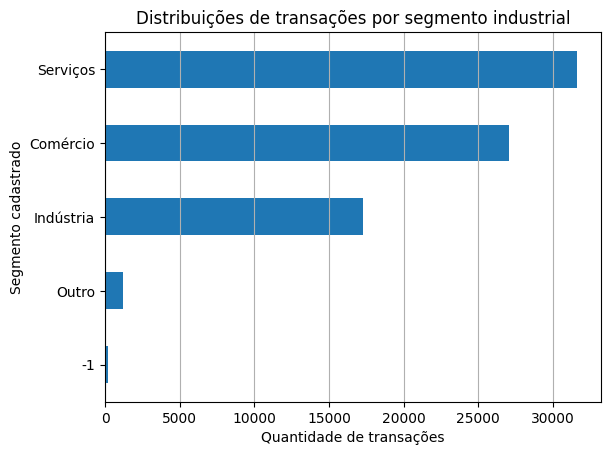

In [31]:
df_modelagem["SEGMENTO_INDUSTRIAL"].value_counts().sort_values().plot(kind="barh")
plt.title("Distribuições de transações por segmento industrial")
plt.ylabel("Segmento cadastrado")
plt.xlabel("Quantidade de transações")
plt.grid(axis="x")
plt.show()

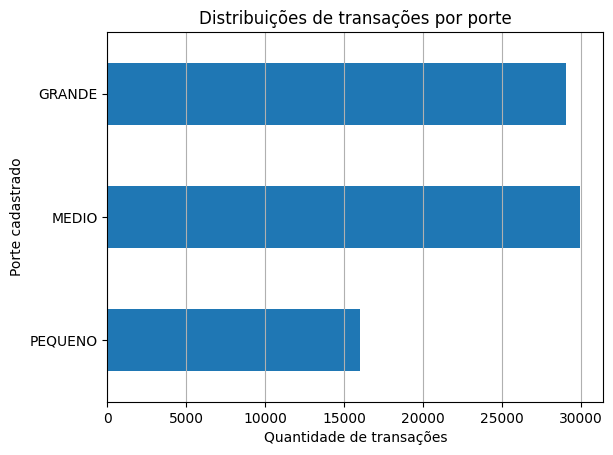

In [32]:
df_modelagem["PORTE"].value_counts().reindex(["PEQUENO", "MEDIO", "GRANDE"]).plot(
    kind="barh"
)
plt.title("Distribuições de transações por porte")
plt.ylabel("Porte cadastrado")
plt.xlabel("Quantidade de transações")
plt.grid(axis="x")
plt.show()

In [43]:
print("Distribuição de pessoas físicas e jurídicas")
round(df_modelagem["FLAG_PF"].value_counts(normalize=True) * 100, 2)

Distribuição de pessoas físicas e jurídicas


FLAG_PF
0.0    99.72
1.0     0.28
Name: proportion, dtype: float64

In [44]:
print("Distribuição de inadimplentes")
round((df_modelagem["INADIMPLENTE"].value_counts(normalize=True) * 100), 2)

Distribuição de inadimplentes


INADIMPLENTE
False    94.21
True      5.79
Name: proportion, dtype: float64

Com base nas análises acima, é possível verificar alguns fatos:
* O setor de serviços é o que mais tem transações cadastradas na base de modelage
* Clientes de porte médio e grande realizaram mais empréstimos no banco que deu origem aos dados
* Há uma discrepância na quantidade de transações de pessoas físicas e jurídicas. A diferença nas quantidades identificada na base cadastral aumentou ao se observar a quantidade de transações
* Há um desbalanceamento entre as classes possíveis da variável alvo. Isso é de suma importância na definição da métrica de avaliação utilizada, uma vez que um modelo que preveja sempre que uma transação não é inadimplente teria acurácia de 94,21%, o que pode gerar uma ilusão.

### Variáveis numéricas

Observemos, abaixo, as estatísticas e distribuições referentes às variáveis numéricas

Primeiramente, para avaliar uma importante estatística da base de dados, um novo atributo será criado. A *feature* `PRAZO_PAGAMENTO` será criada, representando a diferença, em dias, entre a data de emissão do documento (`DATA_EMISSAO_DOCUMENTO`) e a data de vencimento (`DATA_VENCIMENTO`).

In [45]:
df_modelagem["PRAZO_PAGAMENTO"] = (
    df_modelagem["DATA_VENCIMENTO"] - df_modelagem["DATA_EMISSAO_DOCUMENTO"]
).dt.days

In [56]:
# Selecionar colunas numéricas sem ID_CLIENTE E datas de pagamento, vencimento e emissão
colunas_numericas = df_modelagem.describe().columns[4:]

In [61]:
df_modelagem[colunas_numericas].describe()

,VALOR_A_PAGAR,TAXA,DIFERENCA_DIAS,FLAG_PF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,PRAZO_PAGAMENTO
count,7.741400e+04,77414.000000,77414.000000,77414.000000,7.347700e+04,73477.000000,77414.000000
mean,4.656546e+04,6.789623,-0.171429,0.002829,2.909188e+05,117.674170,23.320575
std,4.633892e+04,1.798225,25.229477,0.053113,2.129718e+05,18.776952,26.137018
min,1.000000e-01,4.990000,-2661.000000,0.000000,1.050000e+02,0.000000,-420.000000
25%,1.875275e+04,5.990000,0.000000,0.000000,1.338140e+05,105.000000,16.000000
50%,3.475135e+04,5.990000,0.000000,0.000000,2.404700e+05,118.000000,18.000000
75%,6.088421e+04,6.990000,0.000000,0.000000,3.949130e+05,130.000000,24.000000
max,4.400000e+06,11.990000,869.000000,1.000000,1.682759e+06,198.000000,2677.000000


Na tabela acima, é possível verificar que o valor mínimo do da coluna `PRAZO_PAGAMENTO` é menor do que 0, o que significaria que a data de vencimento seria mais do que a data de emissão do documento.

In [64]:
display(
    df_modelagem[
        df_modelagem["DATA_VENCIMENTO"] < df_modelagem["DATA_EMISSAO_DOCUMENTO"]
    ].head(10)
)

print(
    "Número de registros com data de vencimento menor que a data de emissão do documento"
)
df_modelagem[
    df_modelagem["DATA_VENCIMENTO"] < df_modelagem["DATA_EMISSAO_DOCUMENTO"]
].size

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIFERENCA_DIAS,INADIMPLENTE,DATA_CADASTRO,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,PRAZO_PAGAMENTO
1099,1118514612547157551,2018-09,2018-09-02,2018-09-19,2018-08-27,58434.08,6.99,23,True,2013-10-31,0.0,Serviços,PEQUENO,78,70472.0,87.0,-6
1100,1118514612547157551,2018-09,2018-09-02,2018-09-18,2018-06-20,50000.00,6.99,90,True,2013-10-31,0.0,Serviços,PEQUENO,78,70472.0,87.0,-74
1101,1118514612547157551,2018-09,2018-09-02,2018-09-19,2018-07-25,58434.08,6.99,56,True,2013-10-31,0.0,Serviços,PEQUENO,78,70472.0,87.0,-39
1944,1977574645216036803,2018-09,2018-09-13,2018-09-28,2018-08-31,46674.40,5.99,28,True,2017-02-05,0.0,Indústria,MEDIO,28,553341.0,104.0,-13
2565,8198518259946944874,2018-10,2018-10-12,2019-05-22,2017-11-27,11878.82,4.99,541,True,2013-01-31,0.0,Serviços,MEDIO,70,210562.0,139.0,-319
5009,6020593949794792044,2018-11,2018-11-06,2021-03-23,2018-11-05,278657.56,6.99,869,True,2014-03-27,0.0,Indústria,PEQUENO,95,450205.0,118.0,-1
5481,8198518259946944874,2018-11,2018-11-13,2018-06-19,2017-12-28,255.43,6.99,173,True,2013-01-31,0.0,Serviços,MEDIO,70,217032.0,145.0,-320
8379,8348574220426911086,2019-01,2019-01-03,2019-01-16,2018-12-17,10000.00,6.99,30,True,2011-02-14,0.0,Comércio,PEQUENO,13,98595.0,109.0,-17
16200,4442205629227031623,2019-03,2019-03-24,2019-06-12,2018-12-07,100000.00,5.99,187,True,2013-03-17,0.0,Comércio,MEDIO,44,NaN,NaN,-107
16201,4442205629227031623,2019-03,2019-03-24,2019-06-14,2018-12-07,63000.00,5.99,189,True,2013-03-17,0.0,Comércio,MEDIO,44,NaN,NaN,-107


Número de registros com data de vencimento menor que a data de emissão do documento


459

O ilustrado acima mostra que há 459 registros com data de vencimento sendo anterior à data de emissão do documento. Os casos em que isso acontece serão mantidos assim, pois pode ser importante para os modelos verem casos errados com erros que podem acontecer na vida real.